# Model Training: 1D Convolutional Neural Network
## Stanford TECH 27 Final Project - Notebook 07

This notebook trains a 1D CNN model for SOC estimation using the sequential data prepared in notebooks 04 and 05.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers
import warnings
import pickle
from pathlib import Path
import time

warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")
if len(tf.config.list_physical_devices('GPU')) > 0:
    print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")

Libraries imported successfully!
TensorFlow version: 2.20.0
GPU available: False


## Load CNN Sequential Data

Load the CNN sequential datasets from notebook 05.

In [2]:
# Load CNN sequential data from notebook 05_final_processing.ipynb
OUTPUT_DIR = Path('processed_data')
cnn_datasets_path = OUTPUT_DIR / 'final_cnn_ml_datasets.pkl'

if cnn_datasets_path.exists():
    print(f"Loading CNN sequential datasets from {cnn_datasets_path}...")
    with open(cnn_datasets_path, 'rb') as f:
        cnn_datasets = pickle.load(f)
    
    # Extract the full datasets
    X_train_full = cnn_datasets['X_train']
    X_val_full = cnn_datasets['X_val']
    X_test_full = cnn_datasets['X_test']
    y_train = cnn_datasets['y_train']
    y_val = cnn_datasets['y_val']
    y_test = cnn_datasets['y_test']
    
    # Get all feature names
    all_feature_names = cnn_datasets.get('feature_names', 
                                         [f'feature_{i}' for i in range(X_train_full.shape[2])])
    
    print(f"✅ Successfully loaded CNN datasets from notebook 5")
    print(f"Full dataset shapes:")
    print(f"   Training:   X={X_train_full.shape}, y={y_train.shape}")
    print(f"   Validation: X={X_val_full.shape}, y={y_val.shape}")
    print(f"   Test:       X={X_test_full.shape}, y={y_test.shape}")
    print(f"\nSequence length: {X_train_full.shape[1]} timesteps")
    print(f"Number of features: {X_train_full.shape[2]}")
    
else:
    print(f"❌ Error: Could not find {cnn_datasets_path}")
    print("Please run notebook 05_final_processing.ipynb first to generate the CNN datasets.")
    raise FileNotFoundError(f"Dataset file not found: {cnn_datasets_path}")

Loading CNN sequential datasets from processed_data/final_cnn_ml_datasets.pkl...
✅ Successfully loaded CNN datasets from notebook 5
Full dataset shapes:
   Training:   X=(65297, 60, 45), y=(65297,)
   Validation: X=(20303, 60, 45), y=(20303,)
   Test:       X=(22669, 60, 45), y=(22669,)

Sequence length: 60 timesteps
Number of features: 45


## Filter Features

Filter the dataset to use only the realistic features available from V, I, T measurements.

In [3]:
# Define the specific features to use (same as in notebook 06)
features = [
    # Direct measurements
    'voltage', 'current', 'temperature',
    'Current_load', 'Voltage_load',
    
    # Physics-based calculations from V&I
    'power',
    'abs_current',
    'voltage_current_ratio',
    'energy',
    
    # Time derivatives and changes
    'voltage_change',
    'current_change',
    'power_change',
    'temperature_change',
    
    # Rolling statistics
    'voltage_rolling_mean_5', 'voltage_rolling_mean_10',
    'voltage_rolling_std_5', 'voltage_rolling_std_10',
    'current_rolling_mean_5', 'current_rolling_mean_10',
    'current_rolling_std_5', 'current_rolling_std_10',
    
    # Lagged features
    'voltage_lag_1',
    'current_lag_1',
    
    # Cumulative features
    'cumulative_energy',
]

# Find which features are available in the dataset
available_realistic = [f for f in features if f in all_feature_names]
realistic_indices = [all_feature_names.index(f) for f in available_realistic]

print(f"\nFeature Selection Summary:")
print(f"   Total features in dataset: {len(all_feature_names)}")
print(f"   Realistic features requested: {len(features)}")
print(f"   Realistic features available: {len(available_realistic)}")

print(f"\nUsing {len(available_realistic)} features:")
for i, feat in enumerate(available_realistic, 1):
    print(f"{i:3d}. {feat}")


Feature Selection Summary:
   Total features in dataset: 45
   Realistic features requested: 24
   Realistic features available: 24

Using 24 features:
  1. voltage
  2. current
  3. temperature
  4. Current_load
  5. Voltage_load
  6. power
  7. abs_current
  8. voltage_current_ratio
  9. energy
 10. voltage_change
 11. current_change
 12. power_change
 13. temperature_change
 14. voltage_rolling_mean_5
 15. voltage_rolling_mean_10
 16. voltage_rolling_std_5
 17. voltage_rolling_std_10
 18. current_rolling_mean_5
 19. current_rolling_mean_10
 20. current_rolling_std_5
 21. current_rolling_std_10
 22. voltage_lag_1
 23. current_lag_1
 24. cumulative_energy


## Create Filtered Datasets

In [4]:
# Create filtered datasets with only selected features
X_train = X_train_full[:, :, realistic_indices]
X_val = X_val_full[:, :, realistic_indices]
X_test = X_test_full[:, :, realistic_indices]

print(f"\nFiltered dataset shapes:")
print(f"   Training:   X={X_train.shape}, y={y_train.shape}")
print(f"   Validation: X={X_val.shape}, y={y_val.shape}")
print(f"   Test:       X={X_test.shape}, y={y_test.shape}")
print(f"\nFeature reduction: {X_train_full.shape[2]} → {X_train.shape[2]} features")
print(f"Sequence length: {X_train.shape[1]} timesteps")


Filtered dataset shapes:
   Training:   X=(65297, 60, 24), y=(65297,)
   Validation: X=(20303, 60, 24), y=(20303,)
   Test:       X=(22669, 60, 24), y=(22669,)

Feature reduction: 45 → 24 features
Sequence length: 60 timesteps


## Model Evaluation Functions

In [5]:
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model performance with multiple metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Convert to percentage for SOC
    rmse_percent = rmse * 100
    mae_percent = mae * 100
    
    print(f"\n{model_name} Performance:")
    print(f"  R² Score: {r2:.6f}")
    print(f"  RMSE: {rmse:.6f} ({rmse_percent:.3f}% SOC)")
    print(f"  MAE: {mae:.6f} ({mae_percent:.3f}% SOC)")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2,
            'rmse_percent': rmse_percent, 'mae_percent': mae_percent}

def plot_predictions(y_true, y_pred, model_name, dataset_name=''):
    """Plot predicted vs actual values."""
    plt.figure(figsize=(8, 6))
    
    # Sample for visualization if too many points
    if len(y_true) > 10000:
        sample_idx = np.random.choice(len(y_true), 10000, replace=False)
        y_true_sample = y_true[sample_idx]
        y_pred_sample = y_pred[sample_idx]
    else:
        y_true_sample = y_true
        y_pred_sample = y_pred
    
    plt.scatter(y_true_sample * 100, y_pred_sample * 100, alpha=0.6, s=1)
    
    # Plot perfect prediction line
    plt.plot([0, 100], [0, 100], 'r--', lw=2, label='Perfect Prediction')
    
    plt.xlabel('Actual SOC (%)')
    plt.ylabel('Predicted SOC (%)')
    plt.title(f'{model_name} - Predicted vs Actual {dataset_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add R² score to plot
    r2 = r2_score(y_true, y_pred)
    rmse_percent = np.sqrt(mean_squared_error(y_true, y_pred)) * 100
    plt.text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse_percent:.2f}%', 
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    """Plot training and validation loss over epochs."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # MAE plot
    if 'mae' in history.history:
        axes[1].plot(history.history['mae'], label='Training MAE')
        axes[1].plot(history.history['val_mae'], label='Validation MAE')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('MAE')
        axes[1].set_title('Training and Validation MAE')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Build 1D CNN Model

In [6]:
def build_1d_cnn_model(sequence_length, n_features, filters=[16, 32, 64], 
                       kernel_sizes=[5, 3, 3], dropout_rate=0.6, l2_reg=0.02):
    """
    Build a 1D CNN model for SOC estimation.
    
    Args:
        sequence_length: Length of input sequences
        n_features: Number of features
        filters: List of filter sizes for Conv1D layers
        kernel_sizes: List of kernel sizes for Conv1D layers
        dropout_rate: Dropout rate for regularization
        l2_reg: L2 regularization strength
    """
    from tensorflow.keras import regularizers
    
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(sequence_length, n_features)),
        
        # First Conv1D block
        layers.Conv1D(filters[0], kernel_sizes[0], padding='same', 
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(dropout_rate),
        
        # Second Conv1D block
        layers.Conv1D(filters[1], kernel_sizes[1], padding='same', 
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),  # Remove one conv block and go straight to pooling
        layers.Dropout(dropout_rate),
        
        # Dense layers
        layers.Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')  # Sigmoid for SOC in range [0, 1]
    ])
    
    return model

# Build the model
sequence_length = X_train.shape[1]
n_features = X_train.shape[2]

print("Building 1D CNN model...")
cnn_model = build_1d_cnn_model(
    sequence_length=sequence_length,
    n_features=n_features,
    filters=[16, 32, 64],
    kernel_sizes=[5, 3, 3],
    dropout_rate=0.6,
    l2_reg=0.02
)

# Compile the model
cnn_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='mse',
    metrics=['mae']
)

# Display model architecture
print("\nModel Architecture:")
cnn_model.summary()

# Count parameters
total_params = cnn_model.count_params()
print(f"\nTotal parameters: {total_params:,}")

Building 1D CNN model...

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 60, 16)         │         1,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,913 (19.19 KB)

 Trainable params: 4,753 (18.57 KB)

 Non-trainable params: 160 (640.00 B)


Total parameters: 4,913


## Train the Model

In [ ]:
print("="*60)
print("TRAINING 1D CNN")
print("="*60)

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-8,
    verbose=1
)

model_checkpoint = callbacks.ModelCheckpoint(
    OUTPUT_DIR / 'best_1d_cnn_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Training parameters
batch_size = 1024
epochs = 100

print(f"\nTraining parameters:")
print(f"   Batch size: {batch_size}")
print(f"   Max epochs: {epochs}")
print(f"   Early stopping patience: 7")
print(f"   Learning rate: 0.0001")
print(f"   Learning rate reduction factor: 0.3")
print(f"   Dropout rate: 0.6")
print(f"   L2 regularization: 0.02")
print(f"   Filter sizes: [16, 32, 64]")
print(f"   Architecture: 2 Conv blocks + 1 Dense layer")

# Train the model
print(f"\nStarting training...")
start_time = time.time()

history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"Best epoch: {np.argmin(history.history['val_loss']) + 1}")
print(f"Best validation loss: {np.min(history.history['val_loss']):.6f}")

TRAINING 1D CNN

Training parameters:
   Batch size: 1024
   Max epochs: 100
   Early stopping patience: 7
   Learning rate: 0.0001
   Learning rate reduction factor: 0.3
   Dropout rate: 0.6
   L2 regularization: 0.02
   Filter sizes: [16, 32, 64]
   Architecture: 2 Conv blocks + 1 Dense layer

Starting training...
Epoch 1/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5516 - mae: 0.3138
Epoch 1: val_loss improved from None to 1.42255, saving model to best_1d_cnn_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.5219 - mae: 0.3115 - val_loss: 1.4225 - val_mae: 0.2643 - learning_rate: 1.0000e-04
Epoch 2/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4338 - mae: 0.3016
Epoch 2: val_loss improved from 1.42255 to 1.28851, saving model to best_1d_cnn_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.4043 - mae: 0.2981 - val_loss: 1.2885 - val_mae: 0.2204 - learning_rate: 1.0000e-04
Epoch 3/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3236 - ma

## Visualize Training History

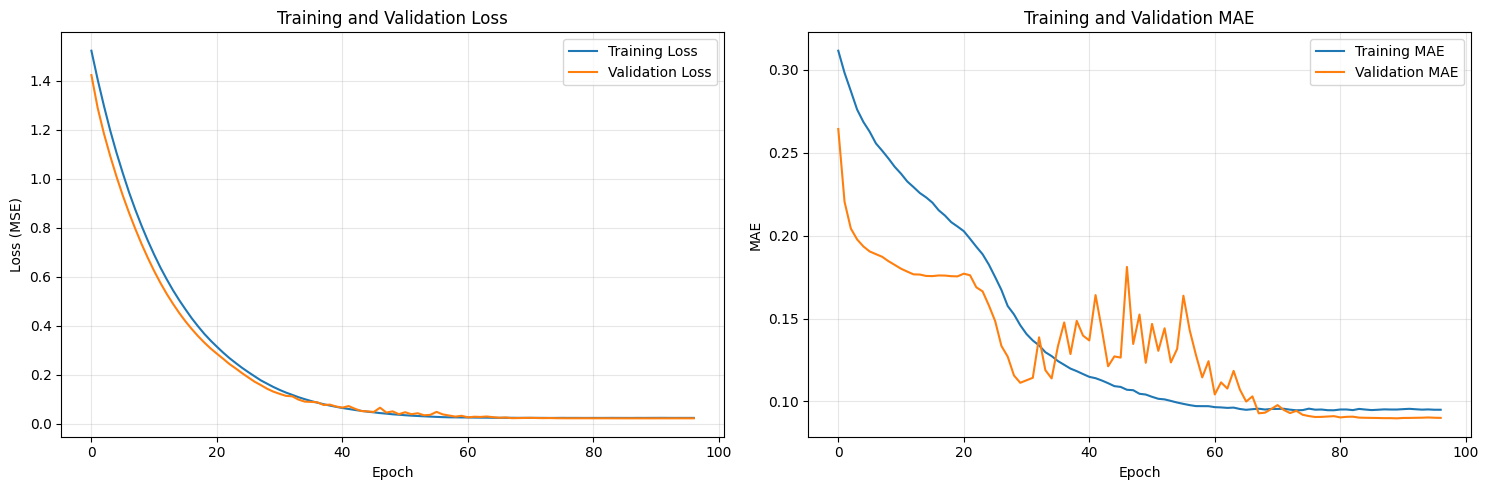


Training Summary:
   Final training loss: 0.023897
   Final validation loss: 0.022190
   Final training MAE: 0.094992
   Final validation MAE: 0.090092
   Total epochs trained: 97


In [8]:
# Plot training history
plot_training_history(history)

# Additional training metrics
print("\nTraining Summary:")
print(f"   Final training loss: {history.history['loss'][-1]:.6f}")
print(f"   Final validation loss: {history.history['val_loss'][-1]:.6f}")
print(f"   Final training MAE: {history.history['mae'][-1]:.6f}")
print(f"   Final validation MAE: {history.history['val_mae'][-1]:.6f}")
print(f"   Total epochs trained: {len(history.history['loss'])}")

## Evaluate Model Performance

In [9]:
# Make predictions
print("Making predictions...")
cnn_train_pred = cnn_model.predict(X_train, batch_size=batch_size, verbose=0).flatten()
cnn_val_pred = cnn_model.predict(X_val, batch_size=batch_size, verbose=0).flatten()
cnn_test_pred = cnn_model.predict(X_test, batch_size=batch_size, verbose=0).flatten()

# Evaluate performance
cnn_train_metrics = evaluate_model(y_train, cnn_train_pred, "1D CNN (Training)")
cnn_val_metrics = evaluate_model(y_val, cnn_val_pred, "1D CNN (Validation)")
cnn_test_metrics = evaluate_model(y_test, cnn_test_pred, "1D CNN (Test)")

print("\n1D CNN evaluation completed.")

Making predictions...

1D CNN (Training) Performance:
  R² Score: 0.755994
  RMSE: 0.112346 (11.235% SOC)
  MAE: 0.083077 (8.308% SOC)

1D CNN (Validation) Performance:
  R² Score: 0.697733
  RMSE: 0.118089 (11.809% SOC)
  MAE: 0.089809 (8.981% SOC)

1D CNN (Test) Performance:
  R² Score: 0.783707
  RMSE: 0.103272 (10.327% SOC)
  MAE: 0.077938 (7.794% SOC)

1D CNN evaluation completed.


## Visualize Predictions

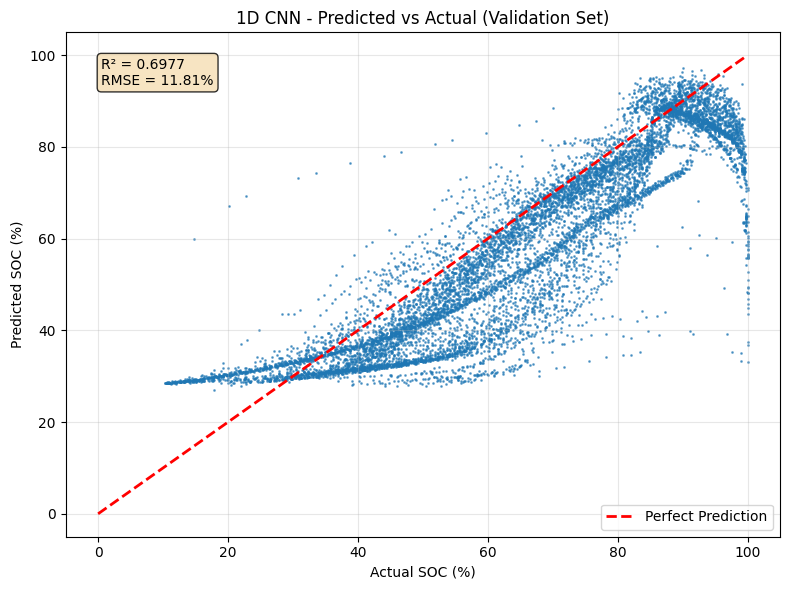

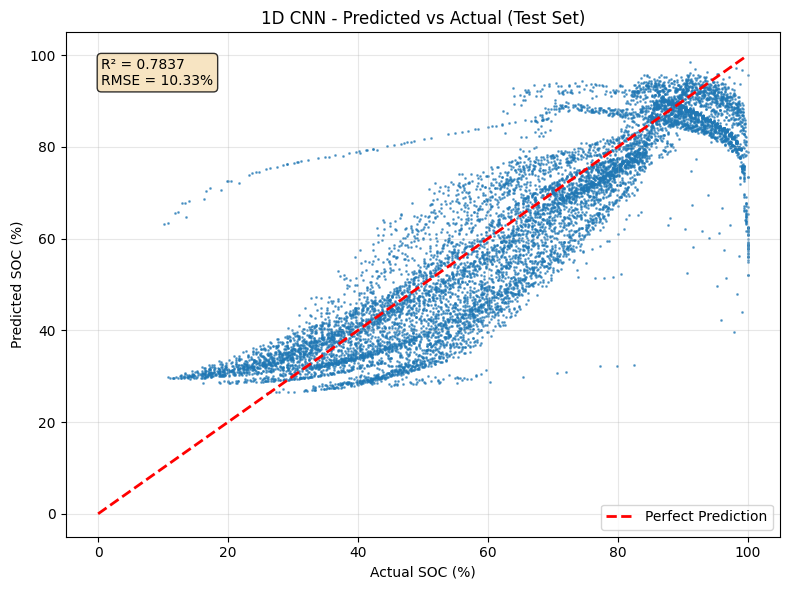

In [10]:
# Visualize predictions on validation set
plot_predictions(y_val, cnn_val_pred, "1D CNN", "(Validation Set)")

# Visualize predictions on test set
plot_predictions(y_test, cnn_test_pred, "1D CNN", "(Test Set)")

## Residual Analysis

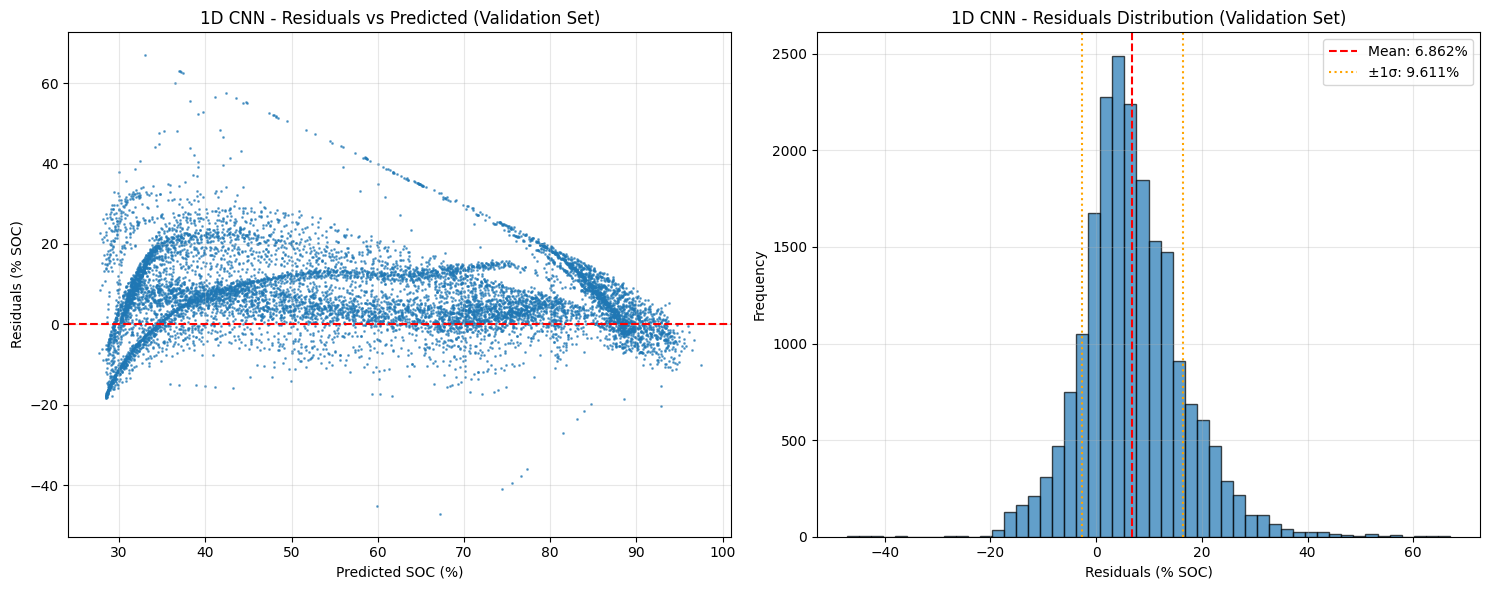

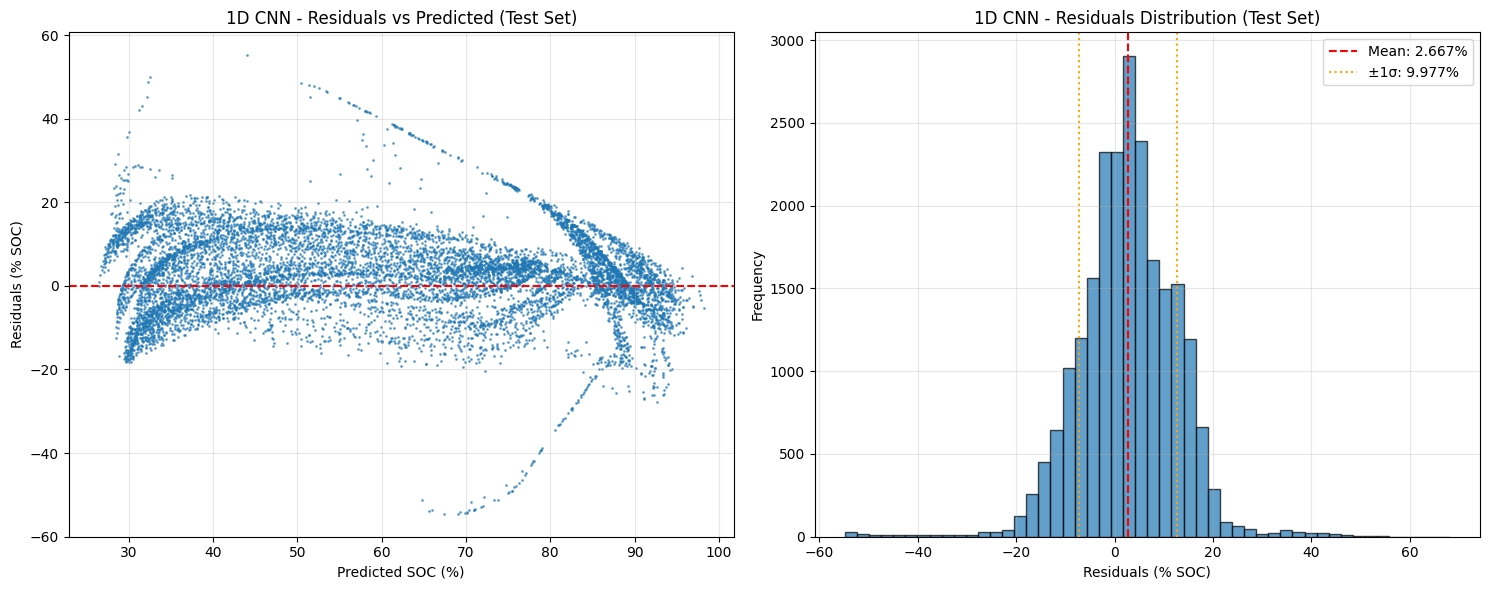

In [11]:
def plot_residuals(y_true, y_pred, model_name, dataset_name=''):
    """Plot residuals to check for patterns."""
    residuals = (y_true - y_pred) * 100  # Convert to percentage
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Sample for visualization if too many points
    if len(y_true) > 10000:
        sample_idx = np.random.choice(len(y_true), 10000, replace=False)
        y_pred_sample = y_pred[sample_idx]
        residuals_sample = residuals[sample_idx]
    else:
        y_pred_sample = y_pred
        residuals_sample = residuals
    
    # Residuals vs Predicted
    axes[0].scatter(y_pred_sample * 100, residuals_sample, alpha=0.6, s=1)
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_xlabel('Predicted SOC (%)')
    axes[0].set_ylabel('Residuals (% SOC)')
    axes[0].set_title(f'{model_name} - Residuals vs Predicted {dataset_name}')
    axes[0].grid(True, alpha=0.3)
    
    # Residuals histogram
    axes[1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Residuals (% SOC)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{model_name} - Residuals Distribution {dataset_name}')
    axes[1].grid(True, alpha=0.3)
    
    # Add statistics
    mean_res = np.mean(residuals)
    std_res = np.std(residuals)
    axes[1].axvline(x=mean_res, color='red', linestyle='--', label=f'Mean: {mean_res:.3f}%')
    axes[1].axvline(x=mean_res + std_res, color='orange', linestyle=':', label=f'±1σ: {std_res:.3f}%')
    axes[1].axvline(x=mean_res - std_res, color='orange', linestyle=':')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Plot residuals for validation and test sets
plot_residuals(y_val, cnn_val_pred, "1D CNN", "(Validation Set)")
plot_residuals(y_test, cnn_test_pred, "1D CNN", "(Test Set)")

## Compare with Baseline Models

Load and compare with results from notebook 06.

MODEL PERFORMANCE COMPARISON

Using 24 features with 60 timesteps

Model                  Train R²     Val R²    Test R²   Test RMSE (%)
---------------------------------------------------------------------------
Linear Regression             -          -   0.208879          19.756
Random Forest                 -          -   0.917825           6.367
XGBoost                       -          -   0.904824           6.852
1D CNN                 0.755994   0.697733   0.783707          10.327


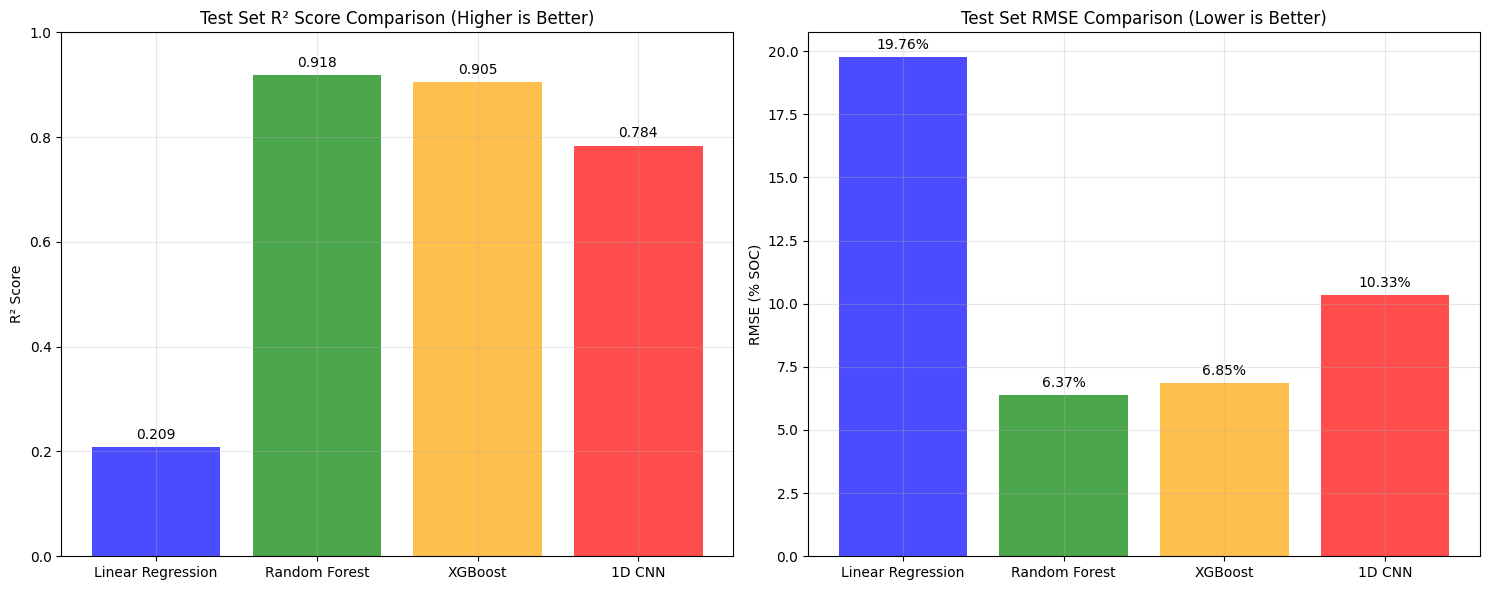

In [12]:
# Create comparison with baseline models from notebook 06
# These are the reported values from notebook 06
baseline_results = {
    'Linear Regression': {'Test_R2': 0.208879, 'Test_RMSE_%': 19.756},
    'Random Forest': {'Test_R2': 0.917825, 'Test_RMSE_%': 6.367},
    'XGBoost': {'Test_R2': 0.904824, 'Test_RMSE_%': 6.852}
}

# Add 1D CNN results
cnn_results = {
    '1D CNN': {
        'Training_R2': cnn_train_metrics['r2'],
        'Training_RMSE_%': cnn_train_metrics['rmse_percent'],
        'Validation_R2': cnn_val_metrics['r2'],
        'Validation_RMSE_%': cnn_val_metrics['rmse_percent'],
        'Test_R2': cnn_test_metrics['r2'],
        'Test_RMSE_%': cnn_test_metrics['rmse_percent']
    }
}

print("="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(f"\nUsing {n_features} features with {sequence_length} timesteps\n")
print(f"{'Model':<20} {'Train R²':>10} {'Val R²':>10} {'Test R²':>10} {'Test RMSE (%)':>15}")
print("-"*75)

# Print baseline results
for model_name, metrics in baseline_results.items():
    print(f"{model_name:<20} {'-':>10} {'-':>10} {metrics['Test_R2']:>10.6f} {metrics['Test_RMSE_%']:>15.3f}")

# Print 1D CNN results
for model_name, metrics in cnn_results.items():
    print(f"{model_name:<20} {metrics['Training_R2']:>10.6f} {metrics['Validation_R2']:>10.6f} "
          f"{metrics['Test_R2']:>10.6f} {metrics['Test_RMSE_%']:>15.3f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# R² comparison
models = list(baseline_results.keys()) + list(cnn_results.keys())
test_r2 = [baseline_results[m]['Test_R2'] for m in baseline_results.keys()] + \
          [cnn_results[m]['Test_R2'] for m in cnn_results.keys()]
colors = ['blue', 'green', 'orange', 'red']

axes[0].bar(models, test_r2, color=colors, alpha=0.7)
axes[0].set_ylabel('R² Score')
axes[0].set_title('Test Set R² Score Comparison (Higher is Better)')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])
for i, (model, score) in enumerate(zip(models, test_r2)):
    axes[0].text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom')

# RMSE comparison
test_rmse = [baseline_results[m]['Test_RMSE_%'] for m in baseline_results.keys()] + \
            [cnn_results[m]['Test_RMSE_%'] for m in cnn_results.keys()]

axes[1].bar(models, test_rmse, color=colors, alpha=0.7)
axes[1].set_ylabel('RMSE (% SOC)')
axes[1].set_title('Test Set RMSE Comparison (Lower is Better)')
axes[1].grid(True, alpha=0.3)
for i, (model, rmse) in enumerate(zip(models, test_rmse)):
    axes[1].text(i, rmse + 0.2, f'{rmse:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Summary

In [13]:
print("="*80)
print("1D CNN MODEL TRAINING SUMMARY")
print("="*80)

print("\nDataset Configuration:")
print(f"   Total features available: {X_train_full.shape[2]}")
print(f"   Features used: {n_features}")
print(f"   Sequence length: {sequence_length} timesteps")
print(f"   Training sequences: {X_train.shape[0]:,}")
print(f"   Validation sequences: {X_val.shape[0]:,}")
print(f"   Test sequences: {X_test.shape[0]:,}")

print("\nModel Architecture:")
print(f"   Total parameters: {total_params:,}")
print(f"   Conv1D layers: 3")
print(f"   Dense layers: 3")
print(f"   Dropout rate: 0.3")

print("\nTraining Results:")
print(f"   Epochs trained: {len(history.history['loss'])}")
print(f"   Training time: {training_time/60:.2f} minutes")
print(f"   Best validation loss: {np.min(history.history['val_loss']):.6f}")

print("\nPerformance Summary:")
print(f"   Training R²: {cnn_train_metrics['r2']:.6f}")
print(f"   Validation R²: {cnn_val_metrics['r2']:.6f}")
print(f"   Test R²: {cnn_test_metrics['r2']:.6f}")
print(f"   Test RMSE: {cnn_test_metrics['rmse_percent']:.3f}% SOC")
print(f"   Test MAE: {cnn_test_metrics['mae_percent']:.3f}% SOC")

# Check for overfitting
train_val_gap = cnn_train_metrics['r2'] - cnn_val_metrics['r2']
status = "✅ Good" if train_val_gap < 0.05 else "⚠️ Mild" if train_val_gap < 0.1 else "❌ Severe"
print(f"\nOverfitting Analysis:")
print(f"   Train-Val R² gap: {train_val_gap:.4f} ({status})")
print(f"   Train-Test R² gap: {cnn_train_metrics['r2'] - cnn_test_metrics['r2']:.4f}")

# Compare with best baseline
best_baseline = 'Random Forest'
best_baseline_r2 = baseline_results[best_baseline]['Test_R2']
best_baseline_rmse = baseline_results[best_baseline]['Test_RMSE_%']

print(f"\nComparison with Best Baseline ({best_baseline}):")
print(f"   Baseline Test R²: {best_baseline_r2:.6f}")
print(f"   1D CNN Test R²: {cnn_test_metrics['r2']:.6f}")
print(f"   R² Difference: {cnn_test_metrics['r2'] - best_baseline_r2:+.6f}")
print(f"   Baseline Test RMSE: {best_baseline_rmse:.3f}% SOC")
print(f"   1D CNN Test RMSE: {cnn_test_metrics['rmse_percent']:.3f}% SOC")
print(f"   RMSE Difference: {cnn_test_metrics['rmse_percent'] - best_baseline_rmse:+.3f}% SOC")

if cnn_test_metrics['r2'] > best_baseline_r2:
    print(f"\n1D CNN outperforms the best baseline model!")
else:
    print(f"\n1D CNN performance is comparable to baseline models.")

1D CNN MODEL TRAINING SUMMARY

Dataset Configuration:
   Total features available: 45
   Features used: 24
   Sequence length: 60 timesteps
   Training sequences: 65,297
   Validation sequences: 20,303
   Test sequences: 22,669

Model Architecture:
   Total parameters: 4,913
   Conv1D layers: 3
   Dense layers: 3
   Dropout rate: 0.3

Training Results:
   Epochs trained: 97
   Training time: 1.90 minutes
   Best validation loss: 0.022125

Performance Summary:
   Training R²: 0.755994
   Validation R²: 0.697733
   Test R²: 0.783707
   Test RMSE: 10.327% SOC
   Test MAE: 7.794% SOC

Overfitting Analysis:
   Train-Val R² gap: 0.0583 (⚠️ Mild)
   Train-Test R² gap: -0.0277

Comparison with Best Baseline (Random Forest):
   Baseline Test R²: 0.917825
   1D CNN Test R²: 0.783707
   R² Difference: -0.134118
   Baseline Test RMSE: 6.367% SOC
   1D CNN Test RMSE: 10.327% SOC
   RMSE Difference: +3.960% SOC

1D CNN performance is comparable to baseline models.


## Save Model and Results

In [ ]:
# Save the model
model_path = OUTPUT_DIR / 'final_1d_cnn_model.keras'
cnn_model.save(model_path)
print(f"✅ Model saved to {model_path}")

# Save results and metrics
results = {
    'model_type': '1D CNN',
    'sequence_length': sequence_length,
    'n_features': n_features,
    'feature_names': available_realistic,
    'total_parameters': total_params,
    'training_time': training_time,
    'epochs_trained': len(history.history['loss']),
    'metrics': {
        'train': cnn_train_metrics,
        'val': cnn_val_metrics,
        'test': cnn_test_metrics
    },
    'history': history.history
}

results_path = OUTPUT_DIR / '1d_cnn_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(results, f)
print(f"✅ Results saved to {results_path}")

✅ Model saved to processed_data/final_1d_cnn_model.keras
✅ Results saved to processed_data/1d_cnn_results.pkl

1D CNN training notebook completed successfully!
